# Power Laws: Cold Start Energy Forecasting


## Background

Building energy forecasting has gained momentum with the increase of building energy efficiency research and solution development. Indeed, forecasting the global energy consumption of a building can play a pivotal role in the operations of the building. 

It provides an initial check for facility managers and building automation systems to mark any discrepancy between expected and actual energy use. Accurate energy consumption forecasts are also used by facility managers, utility companies and building commissioning projects to implement energy-saving policies and optimize the operations of chillers, boilers and energy storage systems.

Usually, forecasting algorithms use historical information to compute their forecast. Most of the time, the bigger the historic dataset, the more accurate the forecast. This requirement presents a big challenge: how can we make accurate predictions for new buildings, which don't have a long consumption history?

![Building Energy](https://www.schneider-electric.co.nz/en/Images/4210283-980x490.jpg) 

source: Schneider-Electric


## Business Objectives

Develop a model to accuratly predict energy consumption for new buildings which don't have a long data consumption history.

The objective is to forecast energy consumption from varying amounts of "cold start" data, and other building information. That means that for each building in the test set there is a small amount of data used to predict into the future.

Three time horizons for predictions are distinguished. The goal is either:

* To forecast the consumption for each hour for a day (24 predictions).
* To forecast the consumption for each day for a week (7 predictions).
* To forecast the consumption for each week for two weeks (2 predictions).
</br>
Reference: https://www.drivendata.org/competitions/55/schneider-cold-start

## Project Notebooks Reference Links

EDA >>> Data Clean-up & Pre_processing >>> Model Fine-tuning | Modelling & Predictions  

# Exploratory Data Analysis¶

## Import Libraries
Import libraries necessary to get the exploratory data analysis (EDA) part of the project set-up

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Energy Forecasting Data Set and Files

Read in the building conspution and meta data files stored in the directory raw into Pandas dataframes

In [3]:
raw_data_directory = "..\\data\\raw\\"
!dir $raw_data_directory

 Volume in drive E is DATA
 Volume Serial Number is 6E98-6AE7

 Directory of E:\GitHub\DataDriven.org\Energy_Forecasting\data\raw

09/30/2018  07:59 PM    <DIR>          .
09/30/2018  07:59 PM    <DIR>          ..
09/30/2018  06:51 PM                 0 .gitkeep
09/29/2018  10:41 AM         6,439,151 cold_start_test.csv
09/30/2018  06:54 PM        29,323,946 consumption_train.csv
09/30/2018  06:54 PM            81,565 meta.csv
09/30/2018  07:59 PM            27,469 meta_df.pkl
09/30/2018  06:55 PM           376,747 submission_format.csv
09/30/2018  07:59 PM         4,767,322 test_df.pkl
09/30/2018  07:59 PM        20,771,586 train_df.pkl
               8 File(s)     61,787,786 bytes
               2 Dir(s)  1,904,299,061,248 bytes free


In [35]:
# Data files to read
csv_data_sets = ['cold_start_test.csv', 'consumption_train.csv', 'meta.csv']
df_list = [] 

df_i = 0
# Read in the training values, training labels and testing data sets
for i in csv_data_sets:
    try:
        data_file = raw_data_directory + i
        df_list.append(pd.read_csv(data_file, header = 0, parse_dates = True, squeeze = True))
        print("Energy Forecasting data files {} has {} samples with {} features each".format(data_file, *df_list[df_i].shape))
    except:
        print("Energy Forecasting data files {} could not be loaded. Is the dataset missing?".format(data_file))
    df_i+=1

Energy Forecasting data files ..\data\raw\cold_start_test.csv has 111984 samples with 5 features each
Energy Forecasting data files ..\data\raw\consumption_train.csv has 509376 samples with 5 features each
Energy Forecasting data files ..\data\raw\meta.csv has 1383 samples with 10 features each


In [36]:
# set up the data frames that we will be using to perform EDA 
test_df = df_list[0]
train_df = df_list[1]
meta_df = df_list[2]
print("Confirm shapes of Pandas dataframes:",test_df.shape, train_df.shape, meta_df.shape)

Confirm shapes of Pandas dataframes: (111984, 5) (509376, 5) (1383, 10)


## Exploration of Features

Below is a data dictionary provided (source:https://www.drivendata.org/competitions/55/schneider-cold-start/page/111/#features_list)

#### Historical consumption data set (consumption_train.csv)

Time series data of consumption and temperature data identified by their series_id.

* series_id - An ID number for the time series, matches across datasets
* timestamp - The time of the measurement
* consumption - Consumption (watt-hours) since the last measurement
* temperature - Outdoor temperature (Celsius) during measurement from nearby weather stations, some values missing

In [37]:
# Look at the first few rows of the consumption train data set
train_df.head()

,Unnamed: 0,series_id,timestamp,consumption,temperature
0,0,103088,2014-12-24 00:00:00,101842.233424,NaN
1,1,103088,2014-12-24 01:00:00,105878.048906,NaN
2,2,103088,2014-12-24 02:00:00,91619.105008,NaN
3,3,103088,2014-12-24 03:00:00,94473.706203,NaN
4,4,103088,2014-12-24 04:00:00,96976.755526,NaN


In [84]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509376 entries, 0 to 509375
Data columns (total 5 columns):
Unnamed: 0     509376 non-null int64
series_id      509376 non-null int64
timestamp      509376 non-null object
consumption    509376 non-null float64
temperature    280687 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 19.4+ MB


In [46]:
# display the number of series/buildings in the training set
serie_list = train_df['series_id'].unique()
len(serie_list)

758

In [67]:
# display the length of each series
df = train_df.groupby(['series_id'])
df.count().head()

,Unnamed: 0,timestamp,consumption,temperature
series_id,,,,
100003,672,672,672,432
100006,672,672,672,0
100008,672,672,672,0
100017,672,672,672,672
100021,672,672,672,0


*** Series number 103088 (lengh:672)


count       672.000000
mean     165689.504391
std       91364.715194
min       77894.519954
25%       99857.137191
50%      138394.253319
75%      165371.172079
max      523671.667426
dtype: float64

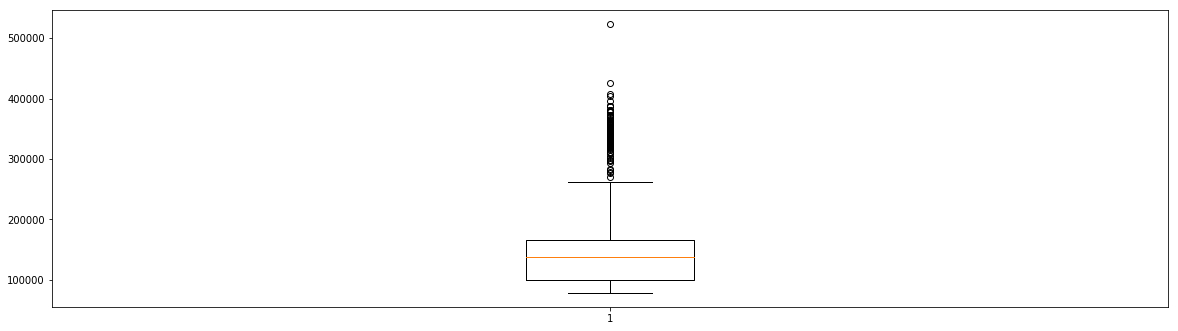

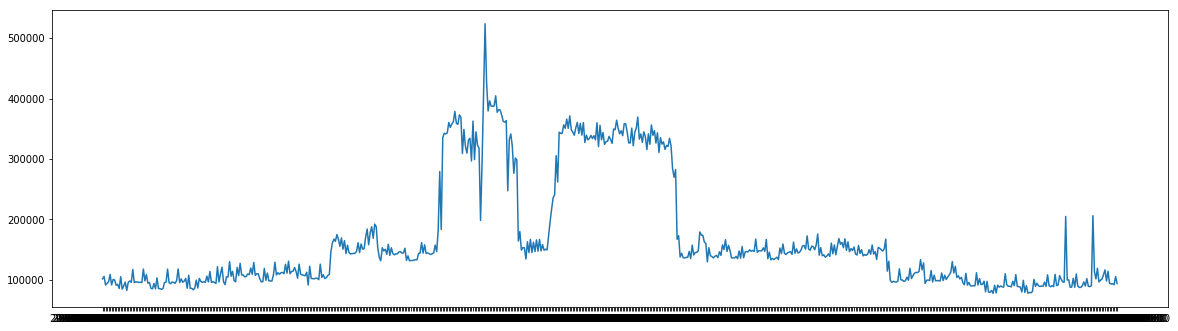

<Figure size 1440x864 with 0 Axes>

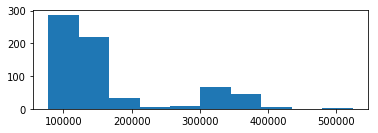

In [135]:
for i in serie_list[:1]:
    ts = pd.Series(df.get_group(i)['consumption'].values, index=df.get_group(i)['timestamp'])
    print("*** Series number {} (lengh:{})".format(i,len(ts)))
    display(ts.describe())
   
    fig = plt.figure(figsize = (20,12))
    plt.subplot(211)
    plt.boxplot(ts)
    plt.show()
    fig = plt.figure(figsize = (20,12))
    plt.subplot(212)
    plt.plot(ts)
    fig = plt.figure(figsize = (20,12))
    plt.show()
    plt.subplot(211)
    plt.hist(ts)
    plt.show()

#### Cold start test data set (cold_start_test.csv)

Test data used to start a forecast. Includes metadata about prediction window as well as time series data on consumption.

* series_id - An ID number for the time series, matches across datasets
* timestamp - The time of the measurement
* consumption - Consumption (watt-hours) since the last measurement
* temperature - Outdoor temperature (Celsius) during measurement from nearby weather stations, some values missing

In [35]:
# Look at the first few rows of the cold start test data set
test_df.head()

,Unnamed: 0,series_id,timestamp,consumption,temperature
0,0,102781,2013-02-27 00:00:00,15295.740389,17.00
1,1,102781,2013-02-27 01:00:00,15163.209562,18.25
2,2,102781,2013-02-27 02:00:00,15022.264079,18.00
3,3,102781,2013-02-27 03:00:00,15370.420458,17.00
4,4,102781,2013-02-27 04:00:00,15303.103213,16.90


In [36]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111984 entries, 0 to 111983
Data columns (total 5 columns):
Unnamed: 0     111984 non-null int64
series_id      111984 non-null int64
timestamp      111984 non-null object
consumption    111984 non-null float64
temperature    67068 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 4.3+ MB


#### Building Metadata data set (meta.csv)

Additional information about the included buildings in the train and test set.

* series_id - An ID number for the time series, matches across datasets
* surface - The surface area of the building (ordinal)
* base_temperature - The base temperature that the inside of the building is set to (ordinal)
* monday_is_day_off - Whether or not the building is operational this day
* tuesday_is_day_off - Whether or not the building is operational this day
* wednesday_is_day_off - Whether or not the building is operational this day
* thursday_is_day_off - Whether or not the building is operational this day
* friday_is_day_off - Whether or not the building is operational this day
* saturday_is_day_off - Whether or not the building is operational this day
* sunday_is_day_off - Whether or not the building is operational this day

In [37]:
# Look at the first few rows of the building meta data set 
meta_df.head()

,series_id,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off
0,100003,x-large,low,False,False,False,False,False,True,True
1,100004,x-large,low,False,False,False,False,False,True,True
2,100006,x-small,low,False,False,False,False,False,True,True
3,100008,x-small,low,False,False,False,False,False,True,True
4,100010,x-small,low,False,False,False,False,False,True,True


In [38]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383 entries, 0 to 1382
Data columns (total 10 columns):
series_id               1383 non-null int64
surface                 1383 non-null object
base_temperature        1383 non-null object
monday_is_day_off       1383 non-null bool
tuesday_is_day_off      1383 non-null bool
wednesday_is_day_off    1383 non-null bool
thursday_is_day_off     1383 non-null bool
friday_is_day_off       1383 non-null bool
saturday_is_day_off     1383 non-null bool
sunday_is_day_off       1383 non-null bool
dtypes: bool(7), int64(1), object(2)
memory usage: 41.9+ KB



## Data Quality Assessment - Missing or Duplicate Data Observations

Use seaborn to create a simple heatmap to check the proportion of missing data

### Check the training data set

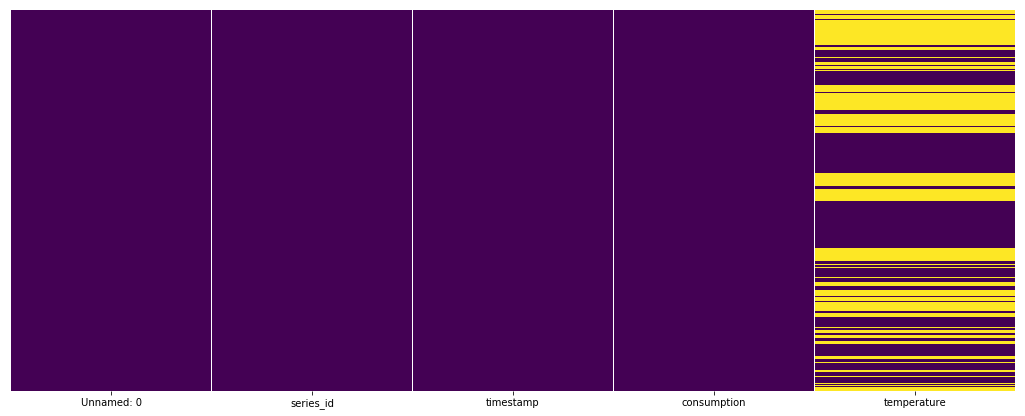

In [71]:
# get an overview of the missing training data fields (NaN) in yellow
plt.figure(figsize=(18, 7))
sns.heatmap(train_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [56]:
# Compute proportion of missing values
num_null_val = train_df.isnull().mean().sort_values(ascending=False).head(20)
num_null_val

temperature    0.448959
consumption    0.000000
timestamp      0.000000
series_id      0.000000
Unnamed: 0     0.000000
dtype: float64

In [45]:
# now check for duplicates
train_df.duplicated().sum()

0

### Check the test data set

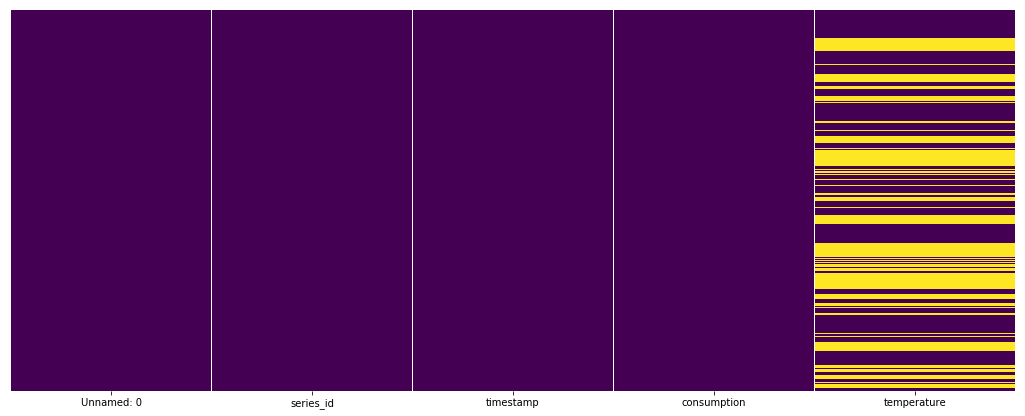

In [72]:
# get an overview of the missing test data fields (NaN) in yellow
plt.figure(figsize=(18, 7))
sns.heatmap(test_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [57]:
# Compute proportion of missing values
num_null_val = test_df.isnull().mean().sort_values(ascending=False).head(20)
num_null_val

temperature    0.401093
consumption    0.000000
timestamp      0.000000
series_id      0.000000
Unnamed: 0     0.000000
dtype: float64

In [47]:
test_df.duplicated().sum()

0

### Check the meta data set

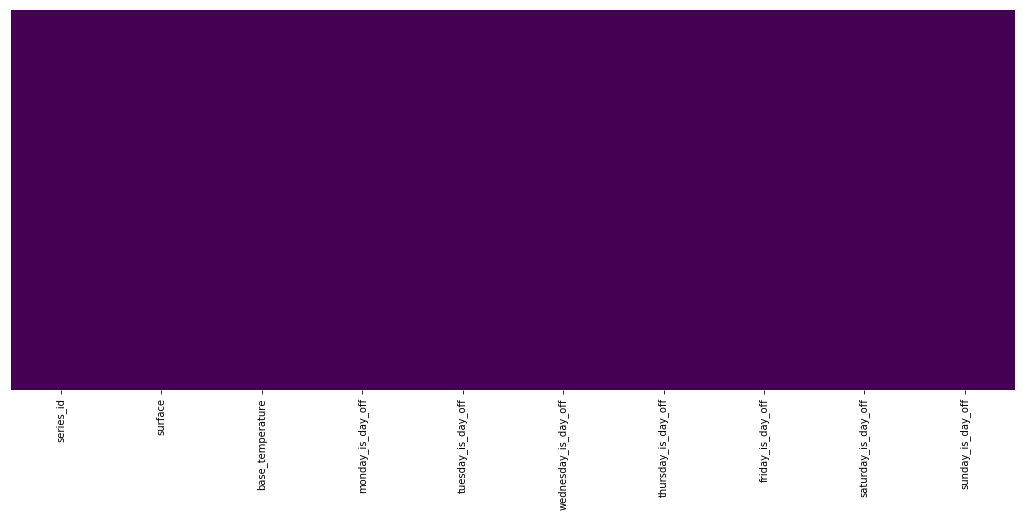

In [73]:
# get an overview of the missing training data fields (NaN) in yellow
plt.figure(figsize=(18, 7))
sns.heatmap(meta_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [58]:
# Compute proportion of missing values
num_null_val = meta_df.isnull().mean().sort_values(ascending=False).head(20)
num_null_val

sunday_is_day_off       0.0
saturday_is_day_off     0.0
friday_is_day_off       0.0
thursday_is_day_off     0.0
wednesday_is_day_off    0.0
tuesday_is_day_off      0.0
monday_is_day_off       0.0
base_temperature        0.0
surface                 0.0
series_id               0.0
dtype: float64

In [59]:
meta_df.duplicated().sum()

0

#### Let's save our pandas data frames to use in the next python notebook

In [68]:
# Save our panda dfs in raw-data
train_df.to_pickle(raw_data_directory + 'train_df.pkl')
test_df.to_pickle(raw_data_directory + 'test_df.pkl')
meta_df.to_pickle(raw_data_directory + 'meta_df.pkl')

In [69]:
!dir $raw_data_directory

 Volume in drive E is DATA
 Volume Serial Number is 6E98-6AE7

 Directory of E:\GitHub\DataDriven.org\Energy_Forecasting\data\raw

09/30/2018  07:59 PM    <DIR>          .
09/30/2018  07:59 PM    <DIR>          ..
09/30/2018  06:51 PM                 0 .gitkeep
09/29/2018  10:41 AM         6,439,151 cold_start_test.csv
09/30/2018  06:54 PM        29,323,946 consumption_train.csv
09/30/2018  06:54 PM            81,565 meta.csv
09/30/2018  07:59 PM            27,469 meta_df.pkl
09/30/2018  06:55 PM           376,747 submission_format.csv
09/30/2018  07:59 PM         4,767,322 test_df.pkl
09/30/2018  07:59 PM        20,771,586 train_df.pkl
               8 File(s)     61,787,786 bytes
               2 Dir(s)  1,904,316,280,832 bytes free


### In the next phase and Jupyter notebook, we will clean and pre-process our data to feed in our ML benchmark (logistic regression)